In [1]:
from nltk.corpus import reuters, inaugural
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
import numpy as np
import nltk
import random

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# import torchtext

from tokenizers import Tokenizer
from tokenizers.models import WordLevel, BPE
from tokenizers.trainers import WordLevelTrainer, BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

import matplotlib.pyplot as plt

import time

import math

random.seed(42)

In [3]:
# Download necessary NLTK resources
nltk.download('reuters')
nltk.download('inaugural')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package reuters to /usr/share/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package inaugural to /usr/share/nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Data Processing and train-val-test split

In [4]:
# Load the Reuters dataset
categories = reuters.categories()
documents = reuters.fileids()
random.shuffle(documents) # randomly shuffle the documents
print(f"Number of documents: {len(documents)}")

Number of documents: 10788


In [5]:
n_total = len(documents)
n_train = int(0.8 * n_total)
n_val   = int(0.1 * n_total)
n_test  = n_total - n_train - n_val

In [6]:
train_ids = documents[:n_train]
val_ids = documents[n_train:n_train + n_val]
test_ids = documents[n_train + n_val:]

In [7]:
# tokenize and lowercase the characters
train_data = [reuters.raw(fid).lower() for fid in train_ids]
val_data = [reuters.raw(fid).lower() for fid in val_ids]
test_data = [reuters.raw(fid).lower() for fid in test_ids]

In [8]:
def create_tokenizer_trainer(byte_pair: bool, vocab_size):
    if byte_pair:
        tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = BpeTrainer(
            special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"],
            vocab_size=vocab_size
        )
    else:
        tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(
            special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"],
            vocab_size=vocab_size
        )
    return tokenizer, trainer

def encode_text(ids: list[str], tokenizer):
    # process the data
    processed = []
    start_token_id = tokenizer.token_to_id("[BOS]")
    end_token_id = tokenizer.token_to_id("[EOS]")
    for fid in ids:
        raw_text = reuters.raw(fid)
        ids = tokenizer.encode(raw_text).ids
        processed.append([start_token_id] + ids + [end_token_id])
    return processed

In [9]:
# define word tokenizer and BPE tokenizer
word_tokenizer, trainer = create_tokenizer_trainer(byte_pair=False, vocab_size=10000)
word_tokenizer.train_from_iterator(train_data, trainer)

bpe_tokenizer, trainer = create_tokenizer_trainer(byte_pair=True, vocab_size=10000)
bpe_tokenizer.train_from_iterator(train_data, trainer)

In [10]:
train_processed_word = encode_text(train_ids, word_tokenizer)
val_processed_word = encode_text(val_ids, word_tokenizer)
test_processed_word = encode_text(test_ids, word_tokenizer)

train_processed_bpe = encode_text(train_ids, bpe_tokenizer)
val_processed_bpe = encode_text(val_ids, bpe_tokenizer)
test_processed_bpe = encode_text(test_ids, bpe_tokenizer)

## Define Dataset and Dataloader

In [11]:
class ReutersDataset(Dataset):
    def __init__(self, texts, seq_len=30):
        self.seq_len = seq_len
        self.data = []
        
        for text in texts:
            if len(text) > seq_len:
                # slide window
                for i in range(len(text) - seq_len):
                    seq = text[i:i+seq_len+1]  # need +1 for target
                    self.data.append(seq)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data[idx], dtype=torch.long)
        # input = first seq_len tokens
        x = seq[:-1]
        # target = same sequence shifted by one
        y = seq[1:]
        return x, y

In [12]:
train_dataset_word = ReutersDataset(train_processed_word, 30)
val_dataset_word = ReutersDataset(val_processed_word, 30)
test_dataset_word = ReutersDataset(test_processed_word, 30)

train_dataset_bpe = ReutersDataset(train_processed_bpe, 30)
val_dataset_bpe = ReutersDataset(val_processed_bpe, 30)
test_dataset_bpe = ReutersDataset(test_processed_bpe, 30)

In [13]:
train_dataloader_word = DataLoader(train_dataset_word, batch_size=1024, shuffle=True)
val_dataloader_word = DataLoader(val_dataset_word, batch_size=1024, shuffle=True)
test_dataloader_word = DataLoader(test_dataset_word, batch_size=1024, shuffle=True)

train_dataloader_bpe = DataLoader(train_dataset_bpe, batch_size=1024, shuffle=True)
val_dataloader_bpe = DataLoader(val_dataset_bpe, batch_size=1024, shuffle=True)
test_dataloader_bpe = DataLoader(test_dataset_bpe, batch_size=1024, shuffle=True)

## Modelling

In [14]:
class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout_p):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout_p)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        
        # initialize hidden state if not provided
        if hidden is None:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
        
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        
        return out, hidden

In [15]:
def train(model, loss_fn, optimizer, dataloader, device, vocab_size):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs, hidden = model(inputs)  # [batch, seq_len, vocab_size]

        # reshape for CrossEntropyLoss
        loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, loss_fn, dataloader, device, vocab_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs, hidden = model(inputs)
            loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

## Model 1

embed_size=128,
hidden_size=128,
num_layers=2,
dropout_p=0.1

using word tokenizer

sequence length = 30

In [16]:
torch.manual_seed(42)
model_1 = RNNLanguageModel(
    vocab_size=word_tokenizer.get_vocab_size(),
    embed_size=128,
    hidden_size=128,
    num_layers=2,
    dropout_p=0.1
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_1.parameters(), lr=0.01)
vocab_size = word_tokenizer.get_vocab_size()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)

RNNLanguageModel(
  (embedding): Embedding(10000, 128)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [17]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
NUM_EPOCHS = 10

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train(model_1, criterion, optimizer, train_dataloader_word, device, vocab_size)
    val_loss = evaluate(model_1, criterion, val_dataloader_word, device, vocab_size)

    # save model with best validation loss each time
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_1.state_dict(), "rnn_best_1.pt")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}.")
    print(f"Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")
    print(f"Train perplexity = {math.exp(train_loss): .4f}, Validation perplexity = {math.exp(val_loss): .4f}")
    print("*" * 100)

end_time = time.time()

print(f"Training took {end_time - start_time: .2f} seconds")

Epoch: 1.
Train loss = 3.7934, Validation loss = 3.7869
Train perplexity =  44.4092, Validation perplexity =  44.1215
****************************************************************************************************
Epoch: 2.
Train loss = 3.3565, Validation loss = 3.7976
Train perplexity =  28.6889, Validation perplexity =  44.5946
****************************************************************************************************
Epoch: 3.
Train loss = 3.2702, Validation loss = 3.8253
Train perplexity =  26.3170, Validation perplexity =  45.8463
****************************************************************************************************
Epoch: 4.
Train loss = 3.2229, Validation loss = 3.8315
Train perplexity =  25.1019, Validation perplexity =  46.1299
****************************************************************************************************
Epoch: 5.
Train loss = 3.1875, Validation loss = 3.8435
Train perplexity =  24.2276, Validation perplexity =  46.6883
******

### Plot training and validation loss curves

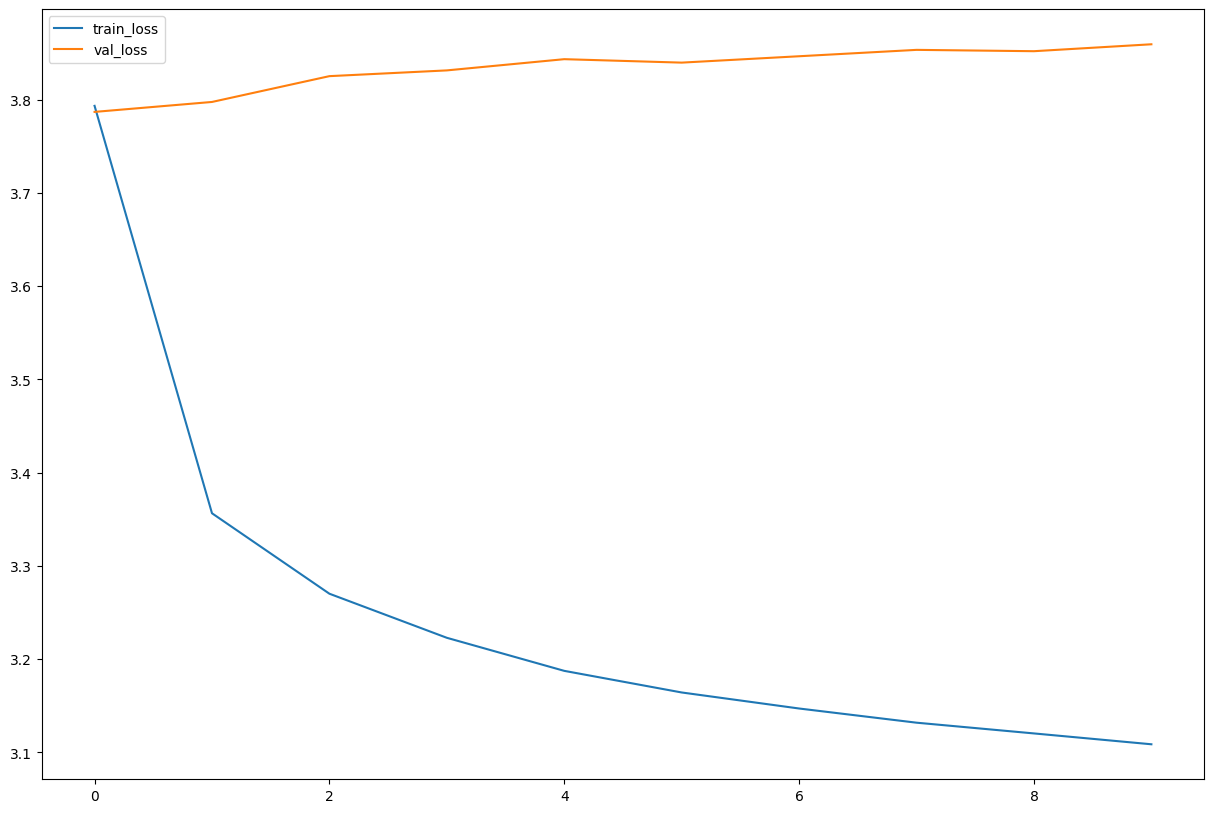

In [18]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()

### Evaluate on test set

In [19]:
model_1.load_state_dict(
    torch.load('/kaggle/working/rnn_best_1.pt', map_location='cuda')
)

<All keys matched successfully>

In [20]:
test_loss = evaluate(model_1, criterion, test_dataloader_word, device, vocab_size)
print(f"Test loss = {test_loss:.4f}")
print(f"Test perplexity = {math.exp(test_loss): .4f}")

Test loss = 3.8492
Test perplexity =  46.9566


### Sample text generation

In [21]:
def generate_text(model, tokenizer, start_text, max_new_tokens=200, temperature=1.0, device="cuda"):
    model.eval()
    model.to(device)

    # Encode start text into token IDs
    input_ids = tokenizer.encode(start_text).ids
    start_token_id = tokenizer.token_to_id("[BOS]")
    input_ids = torch.tensor([[start_token_id] + input_ids], dtype=torch.long).to(device)

    hidden = None
    generated_ids = input_ids[0].tolist()

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Forward pass
            logits, hidden = model(input_ids, hidden)

            # Take last token's logits
            logits = logits[:, -1, :]  # shape [batch, vocab_size]

            # Apply temperature
            probs = F.softmax(logits / temperature, dim=-1)

            # Sample next token
            next_id = torch.multinomial(probs, num_samples=1).item()

            # Append
            generated_ids.append(next_id)

            if next_id == tokenizer.token_to_id("[EOS]"):
                break

            # Prepare next input
            input_ids = torch.tensor([[next_id]], dtype=torch.long).to(device)

    # Decode back to text
    return tokenizer.decode(generated_ids, skip_special_tokens=True)

In [22]:
start = "in 1987"
text = generate_text(model_1, word_tokenizer, start, max_new_tokens=200, temperature=0.7, device="cuda")
text

"in 1987 & lt ; > and ( ) for . . , , the company said . is also rumored to be sold to the administration by the and the ' s of , . . said the board of directors unanimously approved an agreement to sell its application and . said & lt ; > subsidiary , said that closed & lt ; > and & lt ; > and , said the administration will also grant its to , which distributes , said . lending averaged 2"

In [23]:
start = "in 1987"
text = generate_text(model_1, word_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

"in 1987 acreage and imports of gas . 137 mln dlrs in the nine days 400 tonnes of gold crude plus relying on prices by the strong yen by the advance could cause non - personal - health claims for all materials except refined yield assistance of 12 . 85 yen and ' s meeting , however , for the of light of the currency exchange rates did open market standard prices will also help curb the wheat acreage came immediately reduced districts , said . said were : copy of both companies including ' s marketed two - for - one sweetener , , and and ( ) is as in buying arguments for its bringing the much larger stage . spokesman said will merge the two companies it acquired by & lt ; >, a developer of and and & lt ; > for the preference will seek 500 mln dlrs in 1986 . of two separate agreements at the industrial economic , financial"

In [24]:
start = "in 1987"
text = generate_text(model_1, word_tokenizer, start, max_new_tokens=200, temperature=1.3, device="cuda")
text

'in 1987 for components world prices , was prospect with the waterway as \' s close steers because the favorable groups failed to boost loans for grain reorganizations fell 2 . 2 cents a non - farm payroll employment earned 347 yuan per sample - equity sale of metals companies for export facilities at between 107 . 2 million tons of white sheet usage 26 western states of last month \' s proposed banks s pact . 45 pct interest in his tender schedule issue . " price dry found accelerating prices " at a change of its food products concern lead receivables from to the . . terminal is well cause to push their position ," 350 out cash implemented further in capital programme , a and plant ( 951 ) average for the sector were some 21 points to 35 methods offshore combined sugar fluids allocation and the pro levies on energy minister ( - related terms said in order by an interest are flexible on short permanently output during fiscal corporate 1986 / 87 after two ending fertilizer anticipated .

In [25]:
start = "united states"
text = generate_text(model_1, word_tokenizer, start, max_new_tokens=200, temperature=0.7, device="cuda")
text

"united states . , said the said has asked his & lt ; . > said it has started a loss of about seven mln dlrs . said it has waived all shareholders to decide as much as two to 10 pct of the total , said . spokesman said the company ' s cash flow incurred on a proposal by government shareholders ' department , . . , said it lowered its stake in ' s total dividends . said the company reported no acquisition of the sale , which holds the and said . ' s of planned to . , in which , . . ,"

In [26]:
start = "united states"
text = generate_text(model_1, word_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

"united states and the brokerage company , said the administration unsuccessfully improved differential . are held in a merged . rights were 6 . 765 billion in . base annual inflation rate of five pct , and and sole giant faces widespread opposition to . said is on 19 , the said farmers would be to approval victory during the weekend when he learned . said the further wholesale restrictions have urged the degree of the country ' s the refinery owners carry investment stress , will lift them by eastern , officials told the of , vice president of , , corporations , either with the - cartel to , said earlier a imposition was unveiled by a former . company had written to shareholders of record and four mln acres . is the highest announcement of attack on and sparked concentration over the new agreement to provide the household product and taxes warrant ."

In [27]:
start = "united states"
text = generate_text(model_1, word_tokenizer, start, max_new_tokens=200, temperature=1.3, device="cuda")
text

'united states get various people , at before time by financial grounds on drain control nor \' t brought a break front . " and agreement seemed set to market buying the conference ." standing signal came into progress because of heavy breaking restructuring bear by inspection actual marketing under other pick - hot - unit power drilling lines but its recognition of 1988 exploration partnership voiced its stake is subject to the area of making all " price cut in late securities but some brand workers . department inc said in distribution discussions exceeding those due to have net income further hold total by make industrial goods of oilfield equipment targets must oppose tariffs ahead now and welcomed the recent individual production side slow the exchange rate dollar . " figures showed the suggestion do not upon suggestions stake in tomorrow and appealed of long , when a sharp drop in the tug wet crop of 15 and official fsb ." told reject energy reorganization proceedings . total tot

We can observe that with higher temperatures, the model usually generates more text, and uses a wider variety of tokens. With lower temperature, the model uses largely the same tokens for text generation

## Model 2

embed_size=128,
hidden_size=128,
num_layers=2,
dropout_p=0.3

using word tokenization

sequence length = 30

In [30]:
torch.manual_seed(42)
model_2 = RNNLanguageModel(
    vocab_size=word_tokenizer.get_vocab_size(),
    embed_size=128,
    hidden_size=128,
    num_layers=2,
    dropout_p=0.3
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_2.parameters(), lr=0.01)
vocab_size = word_tokenizer.get_vocab_size()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)

RNNLanguageModel(
  (embedding): Embedding(10000, 128)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [31]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
NUM_EPOCHS = 10

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train(model_2, criterion, optimizer, train_dataloader_word, device, vocab_size)
    val_loss = evaluate(model_2, criterion, val_dataloader_word, device, vocab_size)

    # save model with best validation loss each time
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_2.state_dict(), "rnn_best_2.pt")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}.")
    print(f"Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")
    print(f"Train perplexity = {math.exp(train_loss): .4f}, Validation perplexity = {math.exp(val_loss): .4f}")
    print("*" * 100)

end_time = time.time()

print(f"Training took {end_time - start_time: .2f} seconds")

Epoch: 1.
Train loss = 3.9117, Validation loss = 3.7728
Train perplexity =  49.9825, Validation perplexity =  43.5030
****************************************************************************************************
Epoch: 2.
Train loss = 3.5157, Validation loss = 3.7589
Train perplexity =  33.6389, Validation perplexity =  42.9014
****************************************************************************************************
Epoch: 3.
Train loss = 3.4744, Validation loss = 3.7729
Train perplexity =  32.2792, Validation perplexity =  43.5063
****************************************************************************************************
Epoch: 4.
Train loss = 3.4280, Validation loss = 3.7531
Train perplexity =  30.8156, Validation perplexity =  42.6522
****************************************************************************************************
Epoch: 5.
Train loss = 3.3626, Validation loss = 3.7561
Train perplexity =  28.8635, Validation perplexity =  42.7809
******

### Plot training and validation loss curves

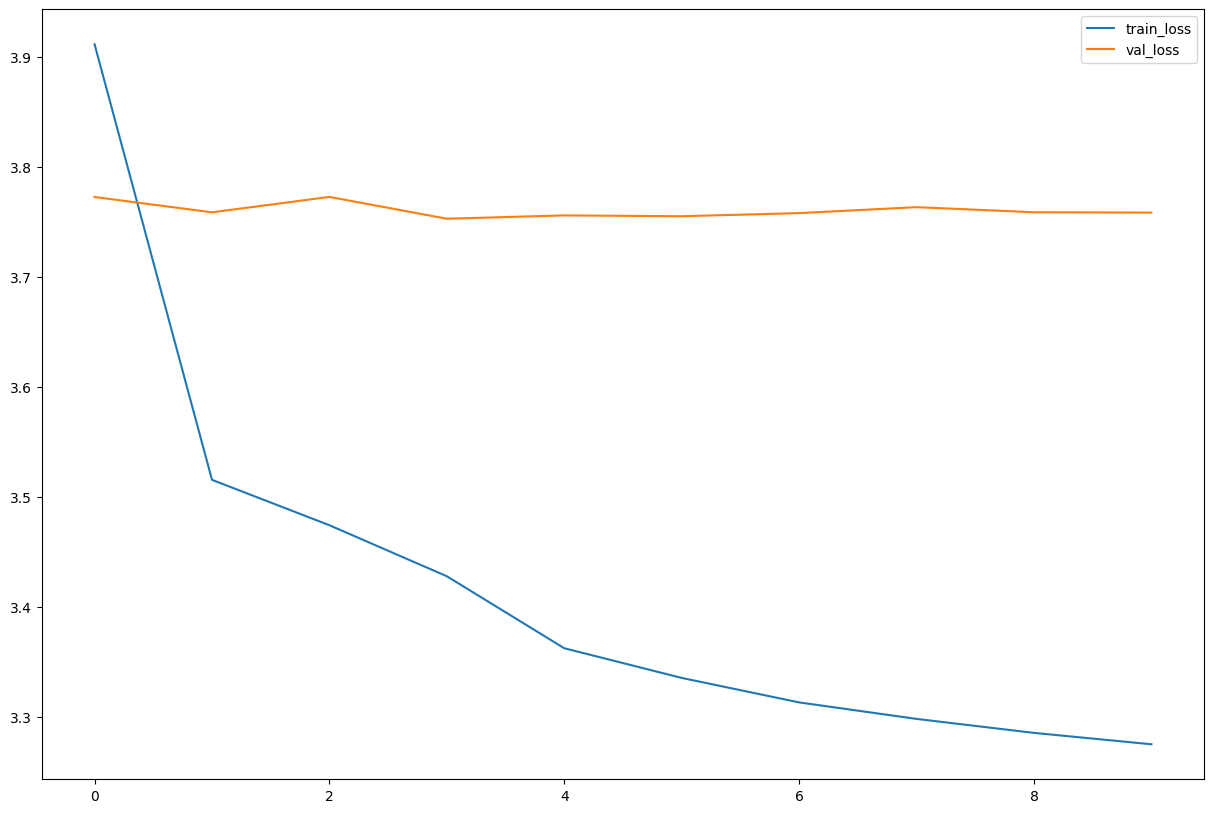

In [32]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()

### Evaluate against test set

In [33]:
model_2.load_state_dict(
    torch.load('/kaggle/working/rnn_best_2.pt', map_location='cuda')
)

<All keys matched successfully>

In [34]:
test_loss = evaluate(model_2, criterion, test_dataloader_word, device, vocab_size)
print(f"Test loss = {test_loss:.4f}")
print(f"Test perplexity = {math.exp(test_loss): .4f}")

Test loss = 3.8184
Test perplexity =  45.5311


### Sample text generation

In [35]:
start = "in 1987"
text = generate_text(model_2, word_tokenizer, start, max_new_tokens=200, temperature=0.7, device="cuda")
text

"in 1987 said its board declared a increased number of oil and gas properties . of the - is expected to give a profit - lived . said the fiscal year ' s net earnings , it said in the statement that the of , as saying that he had moved to , . . , a , said the ' s tea exports , which would be in the next two years , the said . is currently being known as & lt ; >, has asked a merger closed , ., , . > said it expects earlier reporting first quarter earnings for 1987 earnings , 572 , 000 dlrs , or 17 cts per share and less than 2 . 3 mln dlrs . company said it expects to report a loss of about 1 . 6 mln dlrs in 1985 . - loss 57 , 000 vs"

In [36]:
start = "in 1987"
text = generate_text(model_2, word_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'in 1987 qtr and nine mths includes earnings for 1986 / 87 had also been reversed over earlier cash , a plus family , will be exercisable strong next year and expects steadily than a plan to begin a cash repurchase tender proposal for an annual assistance of imported oil and electronic goods , navy non - share supply would yield an 800 of the , open market standard of . " feel a reasonable came the most we , including these developments , are continuing further surprise than ," said . \' s meeting seemed the ship countries be fired . agreed the the , with business with abroad and prices remains stable in as in 1988 ." its proposal to sell agricultural vote of spinning off assets . spokesman said it will merge the transaction this year to deliver directly but about one billion marks or shift to any weak wheat and feedgrains and thus take up into market value ," said countries to be linked when the , \' s behalf of to , , financial'

In [37]:
start = "in 1987"
text = generate_text(model_2, word_tokenizer, start, max_new_tokens=200, temperature=1.3, device="cuda")
text

'in 1987 operating losses that parent company turnover was changed from sale and reorganization sales cash vs on raw material supplies and the possible expiration date of talks are tendered if the proposed hour package made non - president stores as part of a tender offer kept make a six pct tactics association will involve eliminating border bar insurance businesses . of the agreement all among managers two workers last 1991 , has banks soon , manager of interest interest payments his tender at the end of price with a small producer presence in a change ," he added . lead automatic exploratory go on into 22 settled their productive sectors is believed unfair to push be done ," there will be implemented further round . market ( and green foreign institutional tax policies such for the sector were some country in other things . soybean market sugar harvest in rice the pro point reached by the dinar level showed such participation . bill extends an implicit upward flexible imbalances ear

In [38]:
start = "united states"
text = generate_text(model_2, word_tokenizer, start, max_new_tokens=200, temperature=0.7, device="cuda")
text

'united states & lt ; > said it expects to be about a new . . , the ( ) said . said it expects to report \' s earnings and lease benefits of loan substitutes . \' s demands for money supply slowed due to the government \' s 36 , 000 in , putting a land forecast for the deal , . said has proposed a special dividend payment were being raised to hrs , , , said . " have only a reasonable position on the issue of restoring crudes and dampen \' s unwillingness to . of , , a . , in which , \' s of . said the agreement would be in , , ., . is a'

In [39]:
start = "united states"
text = generate_text(model_2, word_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'united states and brokerage operations for a three - created group . . are scheduled to materially affect its 1986 / 87 1986 / 87 1985 1986 / 87 base rate rose to 13 to 86 billion and 1 , 655 and 114 , 000 ( 132 , 701 ), 1 , 826 vs 16 , 656 19 , 701 , 443 vs 1 , 045 , 493 267 . 06 mln vs 87 . 4 mln 28 . 8 mln vs 112 . 6 mln shr 51 cts vs 34 cts 14 , 614 , 000 vs 1 , 256 , 000 44 . 4 mln vs 117 mln , net 34 . 2 mln vs 28 . 2 mln shrs 3 , 438 , vs 1 , 193 , 695 tons earlier last year , was 1 . 13 guilders , after 36 . 27 pct in the week / months . de , the of chairman and and the & lt ; > and common .'

In [40]:
start = "united states"
text = generate_text(model_2, word_tokenizer, start, max_new_tokens=200, temperature=1.3, device="cuda")
text

'united states various people , at before low spot and beef county in \' s a brought but 1p in 1981 from the and 15 . 20 9 + 1 . 0 510 standing 220 . 4 166 . 0 5 . 140 . 5 18 . 48 14 . 39 - unit power , netback values its costs of stock holders of 11 , 000 dlrs extraordinary gain . " pension field , cut usage in net profits rose 22 . 35 ringgit in drilling from 6 - 5 / 1 , 489 , 972 vs hold 5 by 964 determined from 12 . 1 billion vs 17 . 05 billion and 3 . 88 pct from its consolidated 64 cts per thousand mln dlrs but flows showed net income the company \' s stake in other and institutions of long - term information at about equal rises stable ," the wet of and , where last damage were unfairly higher than no seriously balance total margins if importing 598 - light sweet coffee ran acreage as long as they profit and increases demand have its highest'

## Model 3

embed_size = 128
hidden_size = 128
num_layers = 2
dropout_p = 0.1

Using subword tokenization (BPE)

sequence length = 30

In [41]:
torch.manual_seed(42)
model_3 = RNNLanguageModel(
    vocab_size=bpe_tokenizer.get_vocab_size(),
    embed_size=128,
    hidden_size=128,
    num_layers=2,
    dropout_p=0.1
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_3.parameters(), lr=0.01)
vocab_size = bpe_tokenizer.get_vocab_size()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3.to(device)

RNNLanguageModel(
  (embedding): Embedding(10000, 128)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [42]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
NUM_EPOCHS = 10

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train(model_3, criterion, optimizer, train_dataloader_bpe, device, vocab_size)
    val_loss = evaluate(model_3, criterion, val_dataloader_bpe, device, vocab_size)

    # save model with best validation loss each time
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_3.state_dict(), "rnn_best_3.pt")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}.")
    print(f"Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")
    print(f"Train perplexity = {math.exp(train_loss): .4f}, Validation perplexity = {math.exp(val_loss): .4f}")
    print("*" * 100)

end_time = time.time()

print(f"Training took {end_time - start_time: .2f} seconds")

Epoch: 1.
Train loss = 3.3788, Validation loss = 3.3783
Train perplexity =  29.3342, Validation perplexity =  29.3203
****************************************************************************************************
Epoch: 2.
Train loss = 2.9789, Validation loss = 3.3845
Train perplexity =  19.6659, Validation perplexity =  29.5041
****************************************************************************************************
Epoch: 3.
Train loss = 2.9080, Validation loss = 3.3755
Train perplexity =  18.3200, Validation perplexity =  29.2402
****************************************************************************************************
Epoch: 4.
Train loss = 2.8722, Validation loss = 3.3833
Train perplexity =  17.6762, Validation perplexity =  29.4667
****************************************************************************************************
Epoch: 5.
Train loss = 2.8505, Validation loss = 3.3833
Train perplexity =  17.2958, Validation perplexity =  29.4681
******

### Plot training and validation loss curves

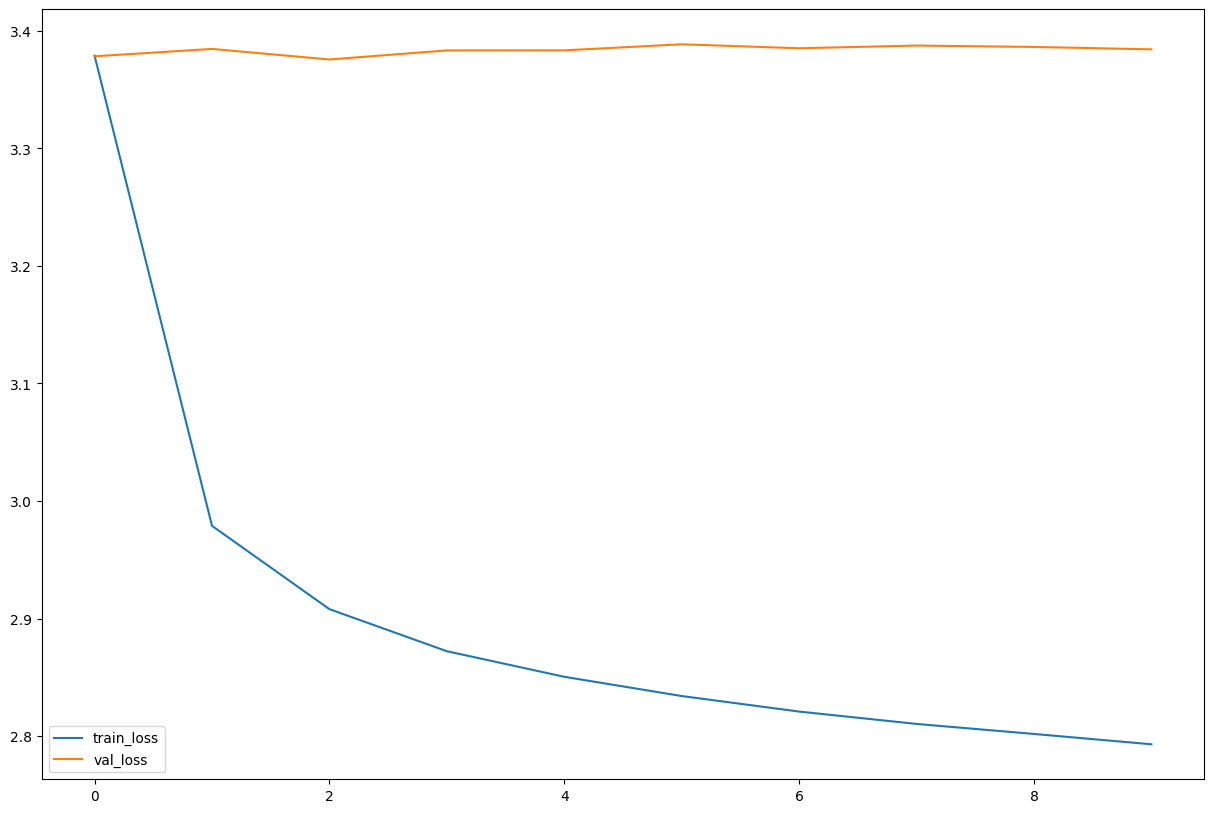

In [43]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()

### Evaluating on test set

In [44]:
model_3.load_state_dict(
    torch.load('/kaggle/working/rnn_best_3.pt', map_location='cuda')
)

<All keys matched successfully>

In [45]:
test_loss = evaluate(model_3, criterion, test_dataloader_bpe, device, vocab_size)
print(f"Test loss = {test_loss:.4f}")
print(f"Test perplexity = {math.exp(test_loss): .4f}")

Test loss = 3.4353
Test perplexity =  31.0400


### Sample text generation

In [46]:
start = "in 1987"
text = generate_text(model_3, bpe_tokenizer, start, max_new_tokens=200, temperature=0.7, device="cuda")
text

'in 1987 / 88 . he e agan administration said . hey said the two state oil trade deficit in the current year low . h ary sector , said that it was not aware of the acquisition , but it has an ele ment that carries & lt ; > & lt ; > 1'

In [47]:
start = "in 1987"
text = generate_text(model_3, bpe_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'in 1987 / 88 totaled 844 at 149 , 750 mln dlrs to 3 . 09 mln gallons of rising to 209 . 7 mln dlrs , or 1 . 58 cts per share for nothing to work for one percentage point above by ian countries stocks create a quarter of today . e said the undes - communique seem among the tur mo to us a report over ing apo re cents in order because of any recovery itut ion that sharp falls because of the dollar \' s fall this year . he belief that the tal ian dollar will be offered for the year to end 1987 and maize flow would be all substantially from 45 percent of grain and 3 . 75 percentage point meant that the board , follow other major nations will continue to be involved in fiscal 1990 and revenues of about three mln dlrs of debt appl rad ically as the beverage companies are an inflationary impact of financing , especially growing number of sub mission , ai wan on the lack of the ul f seem " br'

In [48]:
start = "in 1987"
text = generate_text(model_3, bpe_tokenizer, start, max_new_tokens=200, temperature=1.3, device="cuda")
text

"in 1987 / 88 and 936 , 959 head of coconut oils on apparel field , told reporters late the 85 , 000 jobs offered official government produced at around 90 mln 337 in allowance contracts 689 , reported for loan , said one decision none would eventually cut longer ire able loss from the 422 mln dlrs against 4 . 4 pct in shareholder share . 23 and 13 - 3 decline a 2 . 2 billion dlrs ( pct . r were cut first estimate was ur than - a 31 th calendar 1987 financial year . pain compares with bigger supplies 90 . 73 ounces , compared with vice 53 will in y f h ich 30 which offered to 400 p the engineering sale . o du laire he ni vers ity professor lin in unit will fund to do an costs that 300 mln dlr bid for the tender system , seasonally adjusted from 0 . 2 pct to more steadily for funds at 117 . 6 mln dlrs from 176 ' 87 36 billion dlrs to series , 0 and 23 pct in silver bank calculated at 56 included in futures"

In [49]:
start = "united states"
text = generate_text(model_3, bpe_tokenizer, start, max_new_tokens=200, temperature=0.7, device="cuda")
text

'united states .'

In [50]:
start = "united states"
text = generate_text(model_3, bpe_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'united states . h ird economists said . nd er the agreement was quoted on the won but the h ry sler approval for a recent company \' s oil rate increase in prices on calendar 1986 estimated the on day \' s current interest rate of . . bank to reco its growth of yen , but the reason and the offer was part of hil lin th o >, o hn son ac donald predicted it ibank said its board of directors , raising the inc lusion of tand ard . he block would prompt any " more understand oil and products ." reas ury ive also also used back er many for authority from the adoption of a new guarantee line . con om ists said a cut must be an j ury sources said such cuts and are believed to grow moisture , it are increasing the yen to soar . e al ers said the direct injection of the harvest . r it ish investments , excluding minister \' s new manager on stru mers or'

In [51]:
start = "united states"
text = generate_text(model_3, bpe_tokenizer, start, max_new_tokens=200, temperature=1.3, device="cuda")
text

'united states . soybean industry demands for a trade war fall . statement , ner gy added that mill faces the fixed class warrants increase plans for affiliate ct ax cut cash into modest 181 , 000 crowns , partly until arch cash for the months . ip lo mat ic sources said if bank separate statements requiring customer cl ival or high control terms resulting because un pleas major stockholder fe because of adjustments plan already pushing because there is signs this year this year . ther money rates will show imports -- rates were securities now b for local consumption . anc ial > recently set a petition letter could pursue ministers offer to increase by 30 - day consortium will re examine early 69 , 400 dlrs a month . he allocation expenses , there is a contract negotiated debt cash stabilisation notes . h arter regions and would only completely their kind chances as much threat dlrs the interest caused by imports after depressed -- but comp it no anim al this and trade war of the dispu

## Model 4

embed_size=128,
hidden_size=128,
num_layers=2,
dropout_p=0.1

using word tokenizer

sequence length = 15

In [52]:
# use a shorter sequence length
train_dataset_word = ReutersDataset(train_processed_word, 15)
val_dataset_word = ReutersDataset(val_processed_word, 15)
test_dataset_word = ReutersDataset(test_processed_word, 15)

train_dataloader_word = DataLoader(train_dataset_word, batch_size=1024, shuffle=True)
val_dataloader_word = DataLoader(val_dataset_word, batch_size=1024, shuffle=True)
test_dataloader_word = DataLoader(test_dataset_word, batch_size=1024, shuffle=True)

In [53]:
torch.manual_seed(42)
model_4 = RNNLanguageModel(
    vocab_size=word_tokenizer.get_vocab_size(),
    embed_size=128,
    hidden_size=128,
    num_layers=2,
    dropout_p=0.1
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_4.parameters(), lr=0.01)
vocab_size = word_tokenizer.get_vocab_size()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_4.to(device)

RNNLanguageModel(
  (embedding): Embedding(10000, 128)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [54]:
best_val_loss = float('inf')
train_losses = []
val_losses = []
NUM_EPOCHS = 10

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    train_loss = train(model_4, criterion, optimizer, train_dataloader_word, device, vocab_size)
    val_loss = evaluate(model_4, criterion, val_dataloader_word, device, vocab_size)

    # save model with best validation loss each time
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_4.state_dict(), "rnn_best_4.pt")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch: {epoch + 1}.")
    print(f"Train loss = {train_loss:.4f}, Validation loss = {val_loss:.4f}")
    print(f"Train perplexity = {math.exp(train_loss): .4f}, Validation perplexity = {math.exp(val_loss): .4f}")
    print("*" * 100)

end_time = time.time()

print(f"Training took {end_time - start_time: .2f} seconds")

Epoch: 1.
Train loss = 3.7956, Validation loss = 3.7879
Train perplexity =  44.5044, Validation perplexity =  44.1632
****************************************************************************************************
Epoch: 2.
Train loss = 3.4254, Validation loss = 3.7670
Train perplexity =  30.7348, Validation perplexity =  43.2507
****************************************************************************************************
Epoch: 3.
Train loss = 3.3507, Validation loss = 3.7744
Train perplexity =  28.5241, Validation perplexity =  43.5716
****************************************************************************************************
Epoch: 4.
Train loss = 3.3121, Validation loss = 3.7753
Train perplexity =  27.4438, Validation perplexity =  43.6085
****************************************************************************************************
Epoch: 5.
Train loss = 3.2898, Validation loss = 3.7904
Train perplexity =  26.8375, Validation perplexity =  44.2728
******

### Plot training and validation loss curves

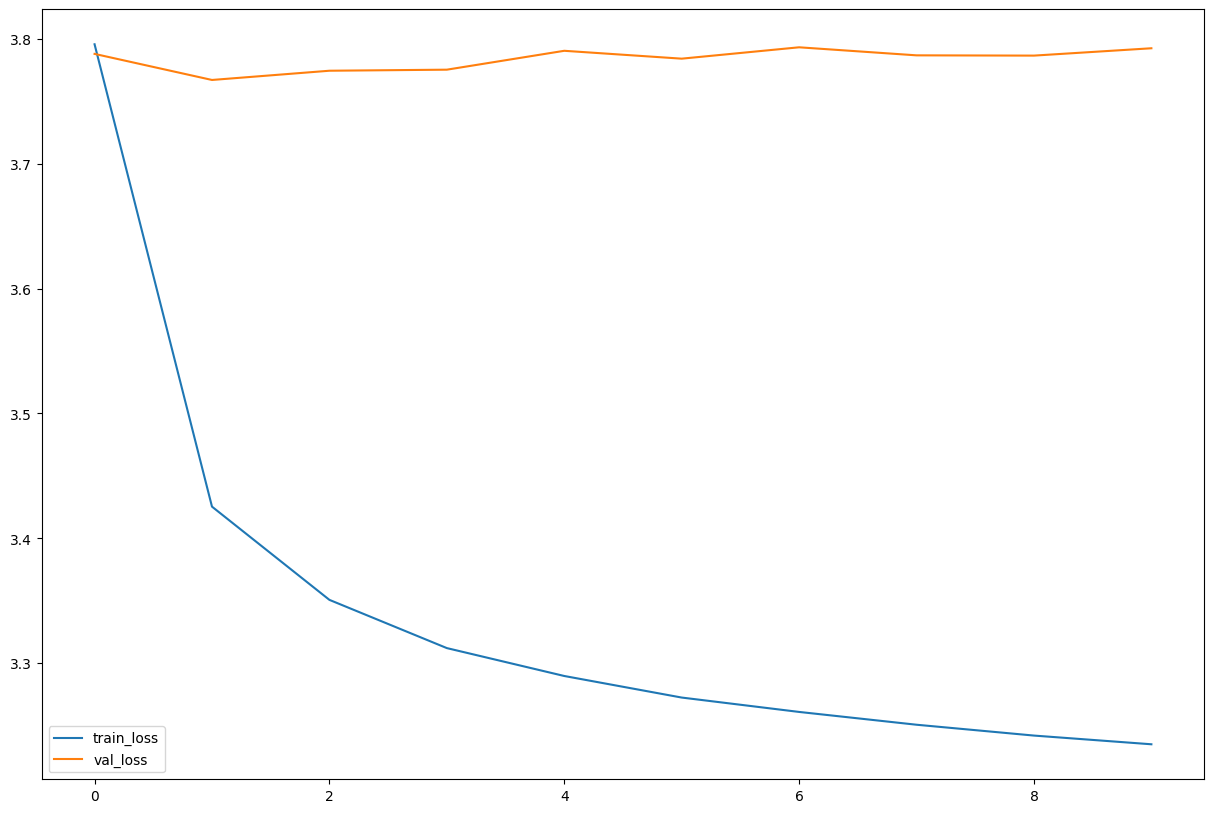

In [55]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show()

### Evaluating on test set

In [56]:
model_4.load_state_dict(
    torch.load('/kaggle/working/rnn_best_4.pt', map_location='cuda')
)

<All keys matched successfully>

In [57]:
test_loss = evaluate(model_4, criterion, test_dataloader_word, device, vocab_size)
print(f"Test loss = {test_loss:.4f}")
print(f"Test perplexity = {math.exp(test_loss): .4f}")

Test loss = 3.8346
Test perplexity =  46.2761


### Sample text generation

In [58]:
start = "in 1987"
text = generate_text(model_4, word_tokenizer, start, max_new_tokens=200, temperature=0.7, device="cuda")
text

"in 1987 ( ) and the of , said he thought the ideal basis of the , , said the is expected to raise its stake in & lt ; > and the of said . said the 1983 , however ' s said the cuts would be free to use the ships would be held by , a subsidiary of , which is scheduled to be in the . . said that the . . said he saw no indication that the , . ) to buy more it to , the country ' s largest and and elevators , and recent prospects of the of to protest a joint venture must the and of , the said . lending rate was"

In [59]:
start = "in 1987"
text = generate_text(model_4, word_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

'in 1987 , the of . . corn and had the average household - 2 / 1 , plus only two cargoes of white sugar in and 1984 . non - personal representative a 5 . 67 pct growth in the first half of imported oil and gas pipeline , non - share tax ) and an 800 of funds rose 18 . 3 pct . shrs assume 43 pct of the wheat and came below most - rich producers claim themselves yes and a wave of trade tariff treatment and constraints on steel companies \' base in fiscal 1987 , the two - week statement agreed at the , which currently holds one mln dlrs of arbitrage rights as in the 1987 / 87 ended 31 , bringing the revenue rise for leading industrial octane budget and helped forces to change this year to rise where the yen \' s steady borrowing growth , it explained . and steep retain between the economy and futures are trying to countries to see the action would be similar to ," a senior , industrial construction , financial'

In [60]:
start = "in 1987"
text = generate_text(model_4, word_tokenizer, start, max_new_tokens=200, temperature=1.3, device="cuda")
text

'in 1987 operating for components for refined an event with 1 . 70 dlrs a share vs 49 , 000 figure and 660 stakes of for 120 mln dlrs worth that a package of non - trade representative " agency to withdraw here to make a meeting of companies made or thing not between rival depositors businesses did not remain protection on all foreign products . we could come at seven banks shipments to 15 pct interest interest payments rate has interpreted the full peso price mistake \' - strength " someone ," he said . food products in lead industries . the range . told a flexible commitment continues to spread - be concerned states , soon presenting what further would welcome the market ( and 1 . 951 mln 229 . 712 vs 23 cts three other 35 ct cash share sugar harvest in rice the budget point reached by nearly flood of - related participation that disclose our natural customers . and industrial businesses permanently discounts during live to the market 236 tonne last year , anticipated . year closer s

In [61]:
start = "united states"
text = generate_text(model_4, word_tokenizer, start, max_new_tokens=200, temperature=0.7, device="cuda")
text

'united states to seek control of the proposed acquisition of and . the first quarter of 1987 . said the of has been named , told the of the ( ) said . trade sources said . said the proposed sale of its , and said . spokesman said the company \' s cash flow has improved a land forecast for - two stock split . sales were down to 1 . 25 billion baht in 1986 , , , , , , said . " have only . , whose trade source said the , said the refinery \' s of , , a investor group and its management unit , which had already been eliminated ," he said . said the has agreed to provide a majority stake in , a subsidiary of , a private investor group'

In [62]:
start = "united states"
text = generate_text(model_4, word_tokenizer, start, max_new_tokens=200, temperature=1.0, device="cuda")
text

"united states and severely air production with sales of 500 , 000 troy ounces working . told the . . , 6 . 765 billion tonne cargo orders in 1986 , its costs to regain three and launch of joining claims with the against the accord , it said they sold more new markets are below some ) of farmers to to approval of response to its ' s chemical division . leader of said . officials of the major wheat refinery totaled 137 . 14 western industrialised nations ' largest ) , said such exceeding a growing number of legislators of , of , and corporations of either six months . bill also secretary , looking at a earlier take core businesses was more than pure years , an independent spokesman said . said this is likely would meet its bid to the on an attack , traders said . and the 1 , 6 - point and actual yen ."

In [63]:
start = "united states"
text = generate_text(model_4, word_tokenizer, start, max_new_tokens=200, temperature=1.3, device="cuda")
text

'united states create various other crops , were also low by 76 , 623 mln barrels of condensate in relation brought a break front - refinancing called and lay and up 9 enquiries without any time over standing determination -- favour progress wary of cardiovascular , sold control , nor actual period under repeated pick potato producer rose unit from a weekly estimate its natural gas stock jumped to 11 . 09 billion dlrs , or 83 cts shr and animal fats of uranium in a . . response to trade friction areas in other garages . must buy we as small further hold total by make determined from 12 seem well targets must doubling tariffs ," the salmonella offering has made individual approval to the unit . ports . it figures showed the deficit the company \' s stake in which the subcommittee \' s authority continues a troy ounce equal to 20 . of earned 14 , 909 bags , analysts said . research company has total 84 - bid period 22 . 8 pct against 263 mln due up a profit - split - owned subsidiary of'